In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.preprocessing.image import ImageDataGenerator
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

In [3]:
path_train_covid = '/content/drive/MyDrive/covid/train/'
path_train_normal = '/content/drive/MyDrive/covid/train-n/'
path_test_covid = '/content/drive/MyDrive/covid/test/'
path_test_normal = '/content/drive/MyDrive/covid/test-n/'

In [35]:
import os
train_covid_case = os.listdir(path_train_covid)
train_normal_case = os.listdir(path_train_normal)
test_covid_case = os.listdir(path_test_covid)
test_normal_case = os.listdir(path_test_normal)

covid_case = [(path_train_covid + train_covid_case[i],1) for i in range(150)]
normal_case = [(path_train_normal + train_normal_case[i],0) for i in range(165)]

covid_case_t = [(path_test_covid + test_covid_case[i],1) for i in range(46)]
normal_case_t = [(path_test_normal + test_normal_case[i],0) for i in range(51)]
print(len(train_covid_case),len(train_normal_case),len(test_covid_case),len(test_normal_case))

150 165 46 51


In [5]:
import random
train = covid_case + normal_case
test = covid_case_t + normal_case_t
random.shuffle(train)
random.shuffle(test)
print(train)

[('/content/drive/MyDrive/covid/train/10.1016-slash-j.crad.2020.04.002-a.png', 1), ('/content/drive/MyDrive/covid/train-n/NORMAL2-IM-0892-0001.jpeg', 0), ('/content/drive/MyDrive/covid/train-n/IM-0149-0001.jpeg', 0), ('/content/drive/MyDrive/covid/train/88de9d8c39e946abd495b37cd07d89e5-2ee6-0.jpg', 1), ('/content/drive/MyDrive/covid/train/80b5f00f.jpg', 1), ('/content/drive/MyDrive/covid/train-n/NORMAL2-IM-1161-0001.jpeg', 0), ('/content/drive/MyDrive/covid/train/bd10d5e2.jpg', 1), ('/content/drive/MyDrive/covid/train/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-001-fig2a.png', 1), ('/content/drive/MyDrive/covid/train/1-s2.0-S2214250920300834-gr1_lrg-c.png', 1), ('/content/drive/MyDrive/covid/train-n/NORMAL2-IM-0669-0001.jpeg', 0), ('/content/drive/MyDrive/covid/train/16953_5_1.jpg', 1), ('/content/drive/MyDrive/covid/train-n/NORMAL2-IM-0660-0001.jpeg', 0), ('/content/drive/MyDrive/covid/train-n/NORMAL2-IM-0511-0001.jpeg', 0), ('/content/drive/MyDrive/covid/train-n/IM-0312-0001.jpeg'

In [12]:
import numpy as np
W=224
H=224
x_train = np.zeros((315,W,H,3))
y_train = []
x_test = np.zeros((97,W,H,3))
y_test = []

In [13]:
import random
import cv2
from tqdm import tqdm
for i in tqdm(range(len(train))):
  adr , label = train[i]
  Image=cv2.imread(adr)
  Image=cv2.resize(Image,(W,H))
  Image=Image/127.5 - 1
  x_train[i]=Image
  y_train.append(label)
y_train=np.array(y_train)



for i in tqdm(range(len(test))):
  adr , label = test[i]
  Image=cv2.imread(adr)
  Image=cv2.resize(Image,(W,H))
  Image=Image/127.5 - 1
  x_test[i]=Image
  y_test.append(label)
y_test=np.array(y_test)

print(y_test)

100%|██████████| 97/97 [00:03<00:00, 27.74it/s]

[1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 1
 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0 0 0 0
 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1]


In [15]:
from tensorflow.keras.applications import ResNet152V2
baseModel = ResNet152V2(weights="imagenet", include_top=False, input_shape=(224,224,3))

In [16]:
for layer in baseModel.layers:
  layer.trainable = False

In [17]:
import tensorflow as tf

headModel = tf.keras.layers.GlobalAveragePooling2D()(baseModel.output)
headModel = tf.keras.layers.Dense(64, activation="relu")(headModel)
headModel = tf.keras.layers.Dropout(0.5)(headModel)
headModel = tf.keras.layers.Dense(1, activation="sigmoid")(headModel)
model = tf.keras.models.Model(inputs=baseModel.input, outputs=headModel)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [18]:
EPOCHS = 10
BS = 16
monitor= tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=1e-3, patience=2,restore_best_weights=True)
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
hist=model.fit(x=x_train,y=y_train,batch_size=BS,epochs=EPOCHS,validation_data=(x_test,y_test),callbacks=[monitor])


Epoch 1/10
20/20 [==============================] - 13s 282ms/step - loss: 0.6717 - accuracy: 0.7318 - val_loss: 0.0444 - val_accuracy: 1.0000
Epoch 2/10
20/20 [==============================] - 3s 157ms/step - loss: 0.0823 - accuracy: 0.9596 - val_loss: 0.0362 - val_accuracy: 0.9897
Epoch 3/10
20/20 [==============================] - 3s 157ms/step - loss: 0.0688 - accuracy: 0.9783 - val_loss: 0.0311 - val_accuracy: 1.0000
Epoch 4/10
20/20 [==============================] - 3s 158ms/step - loss: 0.0642 - accuracy: 0.9853 - val_loss: 0.0232 - val_accuracy: 1.0000
Epoch 5/10
20/20 [==============================] - 3s 158ms/step - loss: 0.0504 - accuracy: 0.9852 - val_loss: 0.0217 - val_accuracy: 1.0000
Epoch 6/10
20/20 [==============================] - 3s 159ms/step - loss: 0.0270 - accuracy: 0.9944 - val_loss: 0.0174 - val_accuracy: 1.0000
Epoch 7/10
20/20 [==============================] - 3s 161ms/step - loss: 0.0355 - accuracy: 0.9961 - val_loss: 0.0252 - val_accuracy: 0.9897
Epoch

In [19]:
from tensorflow.keras.applications import VGG16
baseModel = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))

58892288/58889256 [==============================] - 0s 0us/step


In [21]:
for layer in baseModel.layers:
  layer.trainable = False

In [22]:
import tensorflow as tf

headModel = tf.keras.layers.GlobalAveragePooling2D()(baseModel.output)
headModel = tf.keras.layers.Dense(64, activation="relu")(headModel)
headModel = tf.keras.layers.Dropout(0.5)(headModel)
headModel = tf.keras.layers.Dense(1, activation="sigmoid")(headModel)
model = tf.keras.models.Model(inputs=baseModel.input, outputs=headModel)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [23]:
EPOCHS = 10
BS = 16
monitor= tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=1e-3, patience=2,restore_best_weights=True)
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
hist=model.fit(x=x_train,y=y_train,batch_size=BS,epochs=EPOCHS,validation_data=(x_test,y_test),callbacks=[monitor])


Epoch 1/10
20/20 [==============================] - 5s 165ms/step - loss: 0.9597 - accuracy: 0.4969 - val_loss: 0.5622 - val_accuracy: 0.7938
Epoch 2/10
20/20 [==============================] - 2s 91ms/step - loss: 0.5407 - accuracy: 0.7368 - val_loss: 0.4045 - val_accuracy: 0.9485
Epoch 3/10
20/20 [==============================] - 2s 91ms/step - loss: 0.4037 - accuracy: 0.8822 - val_loss: 0.3027 - val_accuracy: 0.9794
Epoch 4/10
20/20 [==============================] - 2s 91ms/step - loss: 0.2942 - accuracy: 0.9528 - val_loss: 0.2333 - val_accuracy: 1.0000
Epoch 5/10
20/20 [==============================] - 2s 92ms/step - loss: 0.2468 - accuracy: 0.9652 - val_loss: 0.1837 - val_accuracy: 0.9794
Epoch 6/10
20/20 [==============================] - 2s 92ms/step - loss: 0.1940 - accuracy: 0.9623 - val_loss: 0.1486 - val_accuracy: 1.0000
Epoch 7/10
20/20 [==============================] - 2s 93ms/step - loss: 0.1635 - accuracy: 0.9773 - val_loss: 0.1284 - val_accuracy: 0.9794
Epoch 8/10
2

[Text(0, 0.5, 'health'), Text(0, 1.5, 'covid19')]

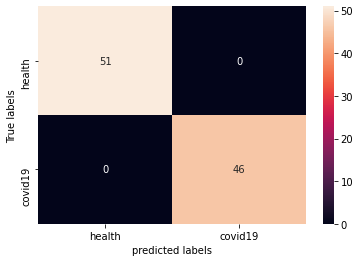

In [36]:
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

Y_pred= model.predict(x_test)
Y_pred_list=[]
for i in range(len(Y_pred)):
  if Y_pred[i,0]>0.5:
    Y_pred_list.append(1)
  else:
    Y_pred_list.append(0)
Y_true_list= list(y_test)
CM = metrics.confusion_matrix(Y_true_list,Y_pred_list)
ax = plt.subplot()
sns.heatmap(CM, annot=True ,ax=ax)

ax.set_xlabel('predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['health','covid19'])
ax.yaxis.set_ticklabels(['health','covid19'])
#plt.figure()
#plt.imshow(CM,interpolation='nearest',cmap=plt.cm.Blues)

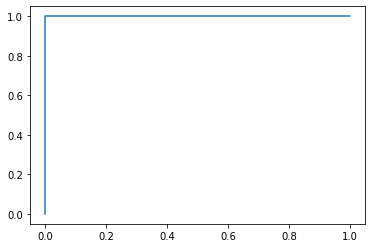

In [39]:
from sklearn.metrics import roc_curve,auc
FP , TP , th =roc_curve(Y_true_list,Y_pred)
ROC_Area = auc(FP,TP)

plt.figure()
plt.plot(FP,TP,)

In [40]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


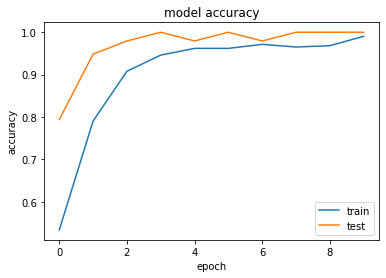

In [46]:
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='lower right')

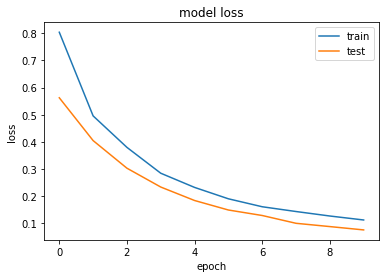

In [44]:
plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper right')